ใน ep นี้เราจะเรียนรู้งานที่สำคัญอีกอย่างหนึ่งใน NLP คือ งานแปลภาษาด้วยเครื่อง หรือ Machine Translation โดยใช้โมเดลแบบ Sequence to Sequence  

โมเดล Seq2Seq จะประกอบด้วย 2 ฝั่ง เรียกว่า 

* Encoder ภายในเป็น โมเดลแบบ RNN ทำหน้าที่รับข้อความภาษาต้นทางมา แล้วแปลงให้อยู่ในรูปของ Vector Representation 
* Decoder ภายในเป็น โมเดลแบบ RNN เช่นกัน ทำหน้าที่รับ Vector Representation ไปสร้างเป็นข้อความภาษาปลายทาง ที่ต้องการ

เปรียบได้ง่าย ๆ ว่า เป็นโมเดลแบบ [RNN](https://www.bualabs.com/archives/3103/what-is-rnn-recurrent-neural-network-what-is-gru-gated-recurrent-unit-teach-how-to-build-rnn-gru-with-python-nlp-ep-9/) / [LSTM](https://www.bualabs.com/archives/3087/sentiment-classification-deep-learning-imdb-movie-reviews-positive-negative-deep-neural-network-awd-lstm-ulmfit-nlp-ep-8/) / [GRU](https://www.bualabs.com/archives/3103/what-is-rnn-recurrent-neural-network-what-is-gru-gated-recurrent-unit-teach-how-to-build-rnn-gru-with-python-nlp-ep-9/) 2 ตัว ต่อกัน รวมกันเป็นตัวเดียว มีเทคนิคการสร้างโมเดล อีกหลายแบบ เช่น ใช้ Attention, ป้อนข้อความย้อนหลัง, ป้อนข้อความสองรอบ, โมเดลสองทิศทาง, เพิ่มความลึกของโมเดล, etc. และนำไปประยุกต์ใช้ได้อีกหลายงาน เช่น Machine translation, Speech recognition, Video captioning, etc. จะอธิบายต่อไป

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [0]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


เช็ค GPU

In [0]:
! nvidia-smi

Tue Dec 17 05:09:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

สำหรับ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) เราจะกำหนด path ที่เก็บ DataSet และ Mount Google Drive 

In [0]:
dataset = '26i-giga-fren'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 2. Dataset

ในเคสนี้เราจะใช้ giga-fren คือ Giga-word corpus สำหรับแปลภาษาระหว่างภาษาฝรั่งเศส-ภาษาอังกฤษ (French-English) จากงาน WMT2010 รวบรวมโดย Chris Callison-Burch

In [0]:
data_path

PosixPath('/content/datasets/26i-giga-fren')

Download ไฟล์มาเก็บไว้ก่อน

In [0]:
# ! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {data_path}

--2019-12-17 05:09:58--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.40.202
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.40.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/content/datasets/26i-giga-fren/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  44.6MB/s    in 52s     

2019-12-17 05:10:50 (47.5 MB/s) - ‘/content/datasets/26i-giga-fren/giga-fren.tgz’ saved [2598183296/2598183296]



แตกไฟล์ ใส่ path ที่กำหนด

In [0]:
# ! tar xf {data_path}/giga-fren.tgz -C {data_path}

ดูว่ามีไฟล์อะไรบ้าง

In [0]:
path = data_path/'giga-fren'
path.ls()

[PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en')]

ดูตัวอย่างข้อมูล ภาษาอังกฤษ

In [0]:
! head {path}/giga-fren.release2.fixed.en

Changing Lives | Changing Society | How It Works | Technology Drives Change Home | Concepts | Teachers | Search | Overview | Credits | HHCC Web | Reference | Feedback Virtual Museum of Canada Home Page
Site map
Feedback
Credits
Français
What is light ?
The white light spectrum Codes in the light The electromagnetic spectrum Emission spectra Absorption spectra Light-years Light pollution
The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone
Cartoon
Links


มี 22520376 บรรทัด

In [0]:
! wc -l {path}/giga-fren.release2.fixed.en

22520376 /content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en


ดูตัวอย่างข้อมูล ภาษาฝรั่งเศส จะเห็นว่าตรงกับด้านบน เป็นคู่ ๆ

In [0]:
! head {path}/giga-fren.release2.fixed.fr

Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada
Plan du site
Rétroaction
Crédits
English
Qu’est-ce que la lumière?
La découverte du spectre de la lumière blanche Des codes dans la lumière Le spectre électromagnétique Les spectres d’émission Les spectres d’absorption Les années-lumière La pollution lumineuse
Le ciel des premiers habitants La vision contemporaine de l'Univers L’astronomie pour tous
Bande dessinée
Liens


มี 22520376 บรรทัด เท่ากัน

In [0]:
! wc -l {path}/giga-fren.release2.fixed.fr

22520376 /content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.fr


# 3. Preprocess

เพื่อความง่ายในการเรียน และจะได้เทรนได้เร็ว Dataset ข้อมูลที่ได้มา เราจะมาคัดเฉพาะประโยคคำถามเท่านั้น

In [0]:
def readfile(d): return [o.strip() for o in open(path/d).readlines()]

In [0]:
# fr = readfile(path/'giga-fren.release2.fixed.fr')
# len(fr)

In [0]:
# en = readfile(path/'giga-fren.release2.fixed.en')
# len(en)

ใช้ [RegEx](https://www.bualabs.com/archives/3070/what-is-regular-expression-regex-regexp-teach-how-to-regex-python-nlp-ep-7/) สกัด เอาเฉพาะประโยคคำถามภาษาอังกฤษออกมา ที่ขึ้นต้นด้วย "Wh" และ ลงท้ายด้วย "?" และประโยคภาษาฝรั่งเศสที่คู่กัน ที่ลงท้ายด้วย ?

In [0]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren.release2.fixed.fr'

In [0]:
lines = ((re_eq.search(eq), re_fq.search(fq))
            for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e, f in lines if e and f]

ได้มาแล้ว Save ใส่ไฟล์ csv ไว้ก่อน

In [0]:
qs = [(q1, q2) for q1, q2 in qs]

df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns=['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

In [0]:
path.ls()

[PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/content/datasets/26i-giga-fren/giga-fren/questions_easy.csv'),
 PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en')]

โหลดไฟล์ CSV ขึ้นมา แสดงตัวอย่างข้อมูล ใน DataFrame

In [0]:
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [0]:
df.tail()

,en,fr
52326,What are the mechanisms for increasing women's...,Quels sont les mécanismes susceptibles d’améli...
52327,"Why is it still pushed aside, silenced, or the...","Pourquoi, aujourd'hui encore, écarte-t-on cett..."
52328,Why should they not demote a judge who rules a...,Pourquoi ne devraient-ils pas destituer un jug...
52329,Why is it that we have achieved judicial indep...,Pourquoi avons-nous réussi à atteindre l'indép...
52330,What's Inside Introduction to STI Did you know…?,Contenu Introduction aux ITS Saviez-vous que…?


เพื่อให้ง่ายขึ้นอีก เราจะแปลงเป็นตัวเล็กให้หมด

In [0]:
df['en'] = df['en'].apply(lambda x: x.lower())
df['fr'] = df['fr'].apply(lambda x: x.lower())

In [0]:
df.head()

,en,fr
0,what is light ?,qu’est-ce que la lumière?
1,who are we?,où sommes-nous?
2,where did we come from?,d'où venons-nous?
3,what would we do without it?,que ferions-nous sans elle ?
4,what is the absolute location (latitude and lo...,quelle sont les coordonnées (latitude et longi...


เนื่องจากข้อความทั้ง 2 ภาษา มีความยาวไม่เท่ากัน ประกาศฟังก์ชัน เรียงรวมข้อมูล โดยใส่ padding ให้ยาวเท่ากัน โมเดลจะได้ทำงานง่ายขึ้น

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    samples = to_data(samples)
    max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx

    if backwards: pad_first = not pad_first
    for i, s in enumerate(samples): 
        if pad_first:
            res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
        else:
            res_x[i, :len(s[0]):], res_y[i, :len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
    if backwards: res_x, res_y = res_x.flip(1), res_y.flip(1)
    return res_x, res_y

ประกาศ Class DataBunch สำหรับ Sequence to Sequence ที่ใช้ Collate ด้านบน และ Sampler แบบ SortishSampler สำหรับ Training Set และ SortSampler สำหรับ Validation Set

SortishSampler คือ เลือกข้อมูลออกมา ตามลำดับความยาวข้อความ ผสมด้วยความ Random เล็กน้อย เหมาะกับใช้สำหรับ Training Set

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', 
               bs:int=32, val_bs:int=None, pad_idx=1, dl_tfms=None, 
               pad_first=False, device:torch.device=None, no_check:bool=False, 
               backwards:bool=False, **dl_kwargs) -> DataBunch:

        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, 
                             pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, 
                                       key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


In [0]:
# SortishSampler??

Seq2SeqTextList มี Label เป็น TextList

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

กำหนด [Data Pipeline ด้วย Data Block API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) 

[Training Set / Validation Set Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) ด้วยการ Random แล้วให้ข้อมูลตัวอย่าง x เป็นประโยคภาษาฝรั่งเศส จาก DataFrame Column fr และ แปะ Label y เป็นประโยคภาษาอังกฤษ จาก DataFrame Column en

In [0]:
src = Seq2SeqTextList.from_df(df, path=path, cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

ดูตำแหน่ง Token ที่ความยาว 90% 

ได้โดยเฉลี่ยไม่เกิน 28 Token สำหรับภาษาฝรั่งเศส และ 23 Token สำหรับ ภาษาอังกฤษ

In [0]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

28.0

In [0]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

23.0

เพื่อความง่าย เราจะลบ ประโยคที่ยาวกว่า 30 Token ในภาษาใดภาษาหนึ่ง (ไม่ถึง 10%) ทิ้งไป

In [0]:
src = src.filter_by_func(lambda x, y: len(x) > 30 or len(y) > 30)

เหลือ 48350 คู่ประโยค

In [0]:
len(src.train) + len(src.valid)

48350

สร้าง DataBunch เอาไว้เตรียม Feed ให้โมเดล

In [0]:
data = src.databunch()

Save ไว้ก่อน คราวหน้าจะได้ไม่ต้อง Preprocess ใหม่

In [0]:
data.save()

In [0]:
# data

In [0]:
path

PosixPath('/content/datasets/26i-giga-fren/giga-fren')

โหลด DataBunch ที่เรา [Preprocess](https://www.bualabs.com/archives/2085/what-is-preprocessing-handle-missing-value-fill-na-null-nan-before-feedforward-machine-learning-preprocessing-ep-1/) เตรียมไว้ก่อนหน้านี้ ขึ้นมา

In [0]:
data = load_data(path)

ดูตัวอย่างข้อมูลใน Batch แรก

In [0]:
data.show_batch()

text,target
"xxbos quels services offrez - vous aux résidents , par l'entremise de votre propre organisation , par l'entremise de liens / partenariats avec des organismes communautaires ou les deux ?",xxbos which of the following services do you offer to residents either through your own organization or through linkages and / or partnerships with community agencies or both ?
"xxbos quelles initiatives ont été prises , conformément aux recommandations précédentes du comité , pour sensibiliser tant les hommes que les femmes à la contraception et aux méthodes xxunk ?","xxbos what steps have been taken , in line with the committee ’s previous recommendations , to raise awareness about contraception and xxunk methods among both men and women ?"
xxbos qu’en est - il d’un leader qui ne possède que deux de ces caractéristiques ou de celui qui ne manifeste que de temps en temps certains comportements xxunk ?,xxbos what if a leader xxunk only two of the factors ?
"xxbos quels mécanismes d'évaluation , de surveillance ou de responsabilisation sont en place pour l'étude de cas , tant dans le cadre de l'initiative qu'à l'intérieur de votre organisation ?","xxbos what evaluation , monitoring or other accountability mechanisms are in place for this work , within the initiative and within your organization ?"
"xxbos quelles sont les hypothèses , selon la définition actuelle du développement , do nt les pays en développement sont censés s'inspirer pour réformer leurs systèmes de politique sociale ?",xxbos what are the assumptions in the current understanding of development that developing countries are expected to accommodate in reforming their social - policy systems ?


# 4. Model

แทนที่จะเทรนแต่ต้นทั้งหมด เราจะใช้ [Transfer Learning](https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/) เพื่อประหยัดเวลา และเพิ่มประสิทธิภาพ แต่ในงานนี้เราจะใช้เฉพาะ [Embedding](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/)

## 4.1 Embedding

โดยในส่วนของ Word [Embedding](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/) เราจะใช้ Pre-trained Word Vector 300 มิติ n-grams ความยาว 5 character, ขนาด window 5 and 10 negatives จาก FastText ของ Facebook ที่เทรนด้วยข้อมูลจาก Common Crawl และ Wikipedia ด้วยวิธี Continuous Bag of Words (CBOW) จะอธิบายต่อไป

In [0]:
! pip install fasttext

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2387750 sha256=e4c50c1b2af7400b44c06094972ae5080a5eff2849f040eb3881604d162ea719
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


Import fasttext

In [0]:
import fasttext as ft

Download [Word Vector](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/) ของทั้งสองภาษา

In [0]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

--2019-12-17 05:42:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/content/datasets/26i-giga-fren/giga-fren/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  26.6MB/s    in 2m 42s  

2019-12-17 05:45:17 (26.5 MB/s) - ‘/content/datasets/26i-giga-fren/giga-fren/cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2019-12-17 05:45:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP

แตกไฟล์ออกมา

In [0]:
# ! gunzip {path}/cc.en.300.bin.gz
# ! gunzip {path}/cc.fr.300.bin.gz

ใช้ fasttext โหลดไฟล์ที่ดาวน์โหลดมา

In [0]:
fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

ประกาศฟังก์ชัน สร้าง Embedding จาก Pre-trained Vector และเติมค่า Vector คำศัพท์ที่ขาดหายไปด้วย ค่า Random

In [0]:
def create_emb(vecs, itos, em_sz=300, multi=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i, w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

สร้าง [Embedding](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/) สำหรับทั้งสองภาษา (Encoder และ Decoder)

In [0]:
emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

จำนวนคำ และขนาดมิติ

In [0]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([11336, 300]), torch.Size([8144, 300]))

In [0]:
model_path = config_path/'My Drive/models'

Save Embedding ที่เราสร้างไว้ 

In [0]:
torch.save(emb_enc, model_path/'fr_emb.pth')
torch.save(emb_dec, model_path/'en_emb.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fasttext ไม่ได้ใช้แล้ว เราจะทำลายทิ้งไป จะได้ไม่เปลือง Memory

In [0]:
del fr_vecs
del en_vecs
gc.collect()

8258

โหลด [Embedding](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/) ขึ้นมา

In [0]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

## 4.2 Sequence to Sequence Model

โมเดลของเราจะแบ่งเป็น 2 ส่วนคือ Encoder แปลงข้อความภาษาอังกฤษ เป็น Vector และ Coder ที่จะ Generate ข้อความภาษาอังกฤษ จาก Vector นั้น

เนื่องจากเราไม่ได้ Transfer Learning ใด ๆ ทั้งสิ้นยกเว้น Embedding ทำให้ Layer ของ [GRU](https://www.bualabs.com/archives/3103/what-is-rnn-recurrent-neural-network-what-is-gru-gated-recurrent-unit-teach-how-to-build-rnn-gru-with-python-nlp-ep-9/) และ [Linear](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) จะถูก [Initialize](https://www.bualabs.com/archives/2633/what-is-lsuv-layer-sequential-unit-variance-initialization-difference-kaiming-initialization-convnet-ep-6/) ด้วยค่า Random

In [0]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl, 
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)

        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl, 
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h

    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:, 0]))
        return h, outp
    
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx

        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs):
        return one_param(self).new_zeros(self.nl, bs, self.nh)


ลองดู [Shape](https://www.bualabs.com/archives/1749/how-to-pytorch-reshape-squeeze-unsqueeze-flatten-manipulate-shape-high-order-dimensions-tensor-ep-2/) ของ [Tensor](https://www.bualabs.com/archives/1629/what-is-tensor-element-wise-broadcasting-operations-high-order-tensor-numpy-array-matrix-vector-tensor-ep-1/) ข้อมูล 1 Batch

In [0]:
xb, yb = next(iter(data.valid_dl))

ขนาด Batch Size = 64 ความยาว 30 Token

In [0]:
xb.shape

torch.Size([64, 30])

สร้าง [Model](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/)

In [0]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [0]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11336, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(8144, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=8144, bias=True)
)

In [0]:
len(xb[0])

30

นำข้อมูล 1 Batch มาผ่าน Encoder ของโมเดล ดู Shape ของ Hidden หรือ Vector Representation ที่จะไปยัง Decoder 

In [0]:
ูh = rnn.encoder(64, xb.cpu())

ได้ออกมาเป็น Hidden 2 Layer ด้วย Batch Size = 64 เป็น Vector 300 มิติ

In [0]:
h.size()

torch.Size([2, 64, 300])

## 4.3 Loss Function

เนื่องจากข้อความ มีความยาวไม่เท่ากัน เราจะใช้ [Loss Function](https://www.bualabs.com/archives/2673/what-is-loss-function-cost-function-error-function-loss-function-how-cost-function-work-machine-learning-ep-1/) แบบปกติไม่ได้ ต้อง Padding ให้เท่ากันก่อนเปรียบเทียบ

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

เนื่องจากข้อความ มีความยาวไม่เท่ากัน เราจะใช้ [Metric](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) เป็น Accuracy แบบปกติไม่ได้ ต้อง Padding ให้เท่ากันก่อนเปรียบเทียบ

In [0]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    out = out.argmax(2)
    return (out == targ).float().mean()

# 5. Train Model

## 5.1 Train โมเดลที่สร้างไว้ด้านบน

สร้าง [Learner](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) จากโมเดลด้านบน เตรียมเทรน

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, callback_fns=[ShowGraph], metrics=[seq2seq_acc])

ใช้ [lr_find](https://www.bualabs.com/archives/2377/lr-find-best-learning-rate-train-machine-learning-model-deep-neural-network-callback-neural-network-ep-12/) หา [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) ที่เหมาะสม

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


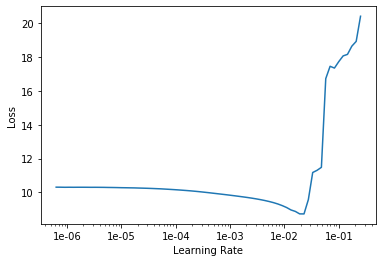

In [0]:
learn.lr_find()
learn.recorder.plot(suggest=True)

ใช้ [Fit One Cycle](https://www.bualabs.com/archives/2452/schedule-hyperparameter-train-machine-learning-deep-neural-network-one-cycle-learning-rate-neural-network-ep-13/) เทรนไป 4 [Epoch](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) ได้ผลลัพธ์พอใช้

epoch,train_loss,valid_loss,seq2seq_acc,time
0,5.592492,5.823976,0.229470,00:39
1,5.107070,4.862986,0.329840,00:34
2,4.539079,4.682736,0.344173,00:35
3,4.174760,4.600675,0.352488,00:36


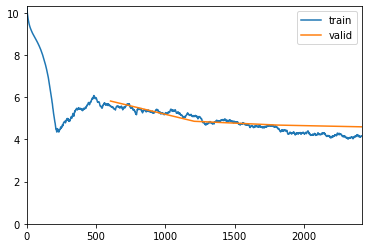

In [0]:
learn.fit_one_cycle(4, 3e-3)

แต่ [Accuracy](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) เป็น [Metrics](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) ที่ไม่ค่อยเหมาะสำหรับงาน Translation สักเท่าไร

Save เก็บไว้ก่อน

In [0]:
learn.save('26i-gru-acc')

In [0]:
learn.load('26i-gru-acc');

## 5.2 Bleu Metric

ในงาน Translation เนื่องจากภาษามนุษย์นั้นดิ้นได้ สมมติให้คน 2 คนแปลข้อความเดียวกัน เป็นไปได้ยากที่จะแปลออกมาเป็นประโยคเดียวกันตรงกันทุกคำ จึงไม่นิยมใช้ Metric ที่เปรียบเทียบคำต่อคำตรง ๆ แบบ [Accuracy](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) แต่นิยมใช้ [Metric](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) ที่เรียกว่า Bleu 

Bleu Score คืออะไร แทนที่จะเปรียบเทียบคำต่อคำ เราจะเปรียบเทียบ [Ngram](https://www.bualabs.com/archives/3060/what-is-n-gram-sentiment-classification-imdb-movie-review-naive-bayes-logistic-regression-nlp-ep-6/) แทน จะอธิบายต่อไป

In [0]:
class NGram():
    def __init__(self, ngram, max_n=50000): self.ngram, self.max_n = ngram, max_n
    def __eq__(self, other): 
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i, o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000): 
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

สร้าง [Callback คำนวน Metrics](https://www.bualabs.com/archives/2358/callback-machine-learning-example-calculate-metrics-avgstats-callback-recorder-loss-learning-rate-neural-network-ep-11/) ทุก Epoch

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'

    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0]*4, [0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i] += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c, t in zip(self.corrects, self.counts)]
        len_penalty = exp(1 - self.targ_len / self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0] * precs[1] * precs[2] * precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)


สร้าง Learner ใหม่ จาก Callback ด้านบน

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))], callback_fns=[ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-08


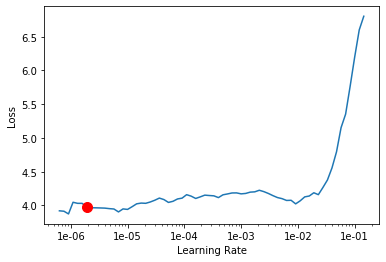

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

เทรนไป 4 Epoch เหมือนเดิม เพิ่มเติมคือ Bleu Score ให้เราเห็นประสิทธิภาพของโมเดลชัดเจนมากขึ้น

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.010732,4.239984,0.388223,0.287723,00:50
1,4.017629,4.648493,0.341126,0.259988,00:49
2,3.462628,4.079413,0.400029,0.311153,00:52
3,2.823382,3.826643,0.427117,0.322879,00:53


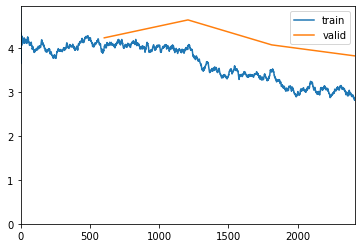

In [0]:
learn.fit_one_cycle(4, 3e-3)

Save ไว้ก่อน

In [0]:
learn.save('26i-gru-bleu')

In [0]:
learn.load('26i-gru-bleu');

## 6. View Result

ดูแต่ Metrics อย่างเดียว อาจจะไม่เห็นภาพ เราจะมาลองดูผลลัพธ์การแปลของจริงกัน

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [], [], []
    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x, y, z in zip(xb, yb, out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs


In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
idx = 999
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quelles sont les données ventilées par sexe pertinentes , qui ne sont pas utilisées habituellement , mais sont disponibles et accessibles ?,
 Text xxbos what relevant gender - xxunk data is not currently used but available and accessible ?,
 Text xxbos what data is is is is is is is is and and are are)

In [0]:
idx = 2222
inputs[idx], targets[idx], outputs[idx]

(Text xxbos avez - vous xxunk des xxunk ou de xxunk en afghanistan parce que vous êtes une femme ?,
 Text xxbos what about yourself xxunk : have you experienced resistance or xxunk in afghanistan because you ’re a woman ?,
 Text xxbos what would you you to you or or or or or xxunk)

In [0]:
idx = 3333
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quels genres d’innovations organisationnelles apporte - t - on à l’intérieur de ce système ?,
 Text xxbos what kinds of organizational innovation takes place in this system ?,
 Text xxbos what kind of types does needed to the ? ?)

In [0]:
idx = 4444
inputs[idx], targets[idx], outputs[idx]

(Text xxbos dans quels cas la discussion informelle a - t - elle lieu ?,
 Text xxbos when does informal discussion occur ?,
 Text xxbos when is the occur ? ?)

ปัญหาคือ ถึงโมเดลจะเริ่มต้นได้ดี แต่แล้วก็จะออกทะเลไปเรื่อย ๆ กลายเป็นคำซ้ำ ๆ ไปจนจบ จะแก้ไขอย่างไรดี

# 5/2 Teacher Forcing

ในการเทรน Decoder ที่เป็น [RNN](https://www.bualabs.com/archives/3103/what-is-rnn-recurrent-neural-network-what-is-gru-gated-recurrent-unit-teach-how-to-build-rnn-gru-with-python-nlp-ep-9/) ตามปกติจะนำ Output มา Feed กลับเป็น Input สำหรับคำต่อไป แต่ถ้าโมเดลยังไม่ค่อยเก่ง Predict Output ออกมาผิด แล้วเรานำ Output ที่ผิดนั้นไป Feed กลับมาเป็น Input ทำให้ Output ต่อ ๆ ไป ผิดเป็นโดมิโนไปหมด วิธีหนึ่งที่จะช่วยให้โมเดล เรียนรู้ได้ดีขึ้น คือ Teacher Forcing

Teacher Forcing คือ การเทรนด้วยแทนที่ จะ Feed Output จากโมเดล เป็น Input อย่างเดียว เราจะ Feed ผสม  Output ที่ถูกต้อง (Label) กับ Output ของโมเดล (Prediction) เข้าด้วยกัน ตามสัดส่วนที่กำหนด แล้วค่อย ๆ ปรับสัดส่วนเพิ่ม Output จากโมเดลขึ้นเรื่อย ๆ ลด Label ลง จนเทรนด้วย Output อย่างเดียว

ประกาศ [Callback](https://www.bualabs.com/archives/2348/how-to-apply-callback-in-training-loop-neural-network-flexible-neural-network-ep-10/) สำหรับทำ Teacher Forcing ที่จะสิ้นสุด ตาม end_epoch ที่กำหนด

In [0]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}

    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

สร้าง Model ใหม่ ที่ใน Forward จะ Random ทำ Teacher Forcing ตาม pr_force จาก Callback

In [0]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl, 
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)

        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl, 
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h

    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:, 0]))
        return h, outp
    
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx

        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i >= targ.shape[1]: continue
                dec_inp = targ[:, i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs):
        return one_param(self).new_zeros(self.nl, bs, self.nh)


โหลด Embedding ขึ้นมาใหม่ เตรียมเทรน

In [0]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

สร้างโมเดล และ Learning ด้วย Callback Teaching Forcing และโมเดลใหม่ ที่รองรับ Teaching Forcing

In [0]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, 
                metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))], 
                callback_fns=[ShowGraph, partial(TeacherForcing, end_epoch=3)])

ใช้ [lr_find](https://www.bualabs.com/archives/2377/lr-find-best-learning-rate-train-machine-learning-model-deep-neural-network-callback-neural-network-ep-12/) หา [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 2.75E-03


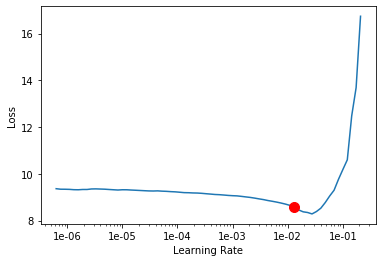

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Schedule Hyperparameter ในการเทรนโมเดล Deep Neural Network ด้วย Learning Rate ไม่คงที่ [Fit One Cycle](https://www.bualabs.com/archives/2452/schedule-hyperparameter-train-machine-learning-deep-neural-network-one-cycle-learning-rate-neural-network-ep-13/)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.603877,5.310301,0.102326,0.033441,01:12
1,2.776709,3.934700,0.457844,0.332081,00:59
2,3.433332,4.561241,0.361745,0.283000,00:52
3,4.450474,5.148569,0.294567,0.235750,00:48
4,3.857798,4.347720,0.374517,0.286468,00:51
5,3.505725,4.136127,0.396483,0.307886,00:51
6,2.940073,3.882642,0.422862,0.321591,00:52
7,2.678760,3.732396,0.439311,0.332833,00:53


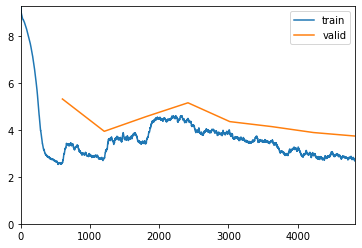

In [0]:
learn.fit_one_cycle(8, max_lr=3e-3)

ได้ผลลัพธ์ดีขึ้น เราจะ Save Learner ไว้ก่อน

In [0]:
learn.save('26i-gru-tf')

In [0]:
learn.load('26i-gru-tf');

# 6/2. View Result

ดูแต่ [Metrics](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) อย่างเดียว อาจจะไม่เห็นภาพ เราจะมาลองดูผลลัพธ์การแปลของจริงกันเปรียบเทียบ

In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
idx = 999
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quelles sont les données ventilées par sexe pertinentes , qui ne sont pas utilisées habituellement , mais sont disponibles et accessibles ?,
 Text xxbos what relevant gender - xxunk data is not currently used but available and accessible ?,
 Text xxbos what data - data is is are , , are are are are are not ? ?)

In [0]:
idx = 2222
inputs[idx], targets[idx], outputs[idx]

(Text xxbos avez - vous xxunk des xxunk ou de xxunk en afghanistan parce que vous êtes une femme ?,
 Text xxbos what about yourself xxunk : have you experienced resistance or xxunk in afghanistan because you ’re a woman ?,
 Text xxbos when you you or or or or or or or or or xxunk xxunk ?)

In [0]:
idx = 3333
inputs[idx], targets[idx], outputs[idx]

(Text xxbos quels genres d’innovations organisationnelles apporte - t - on à l’intérieur de ce système ?,
 Text xxbos what kinds of organizational innovation takes place in this system ?,
 Text xxbos what kind of models does does in this ? ?)

In [0]:
idx = 4444
inputs[idx], targets[idx], outputs[idx]

(Text xxbos dans quels cas la discussion informelle a - t - elle lieu ?,
 Text xxbos when does informal discussion occur ?,
 Text xxbos what is the the ? ? ?)

# 7. สรุป

* เราได้เรียนรู้สถาปัตยกรรมแบบใหม่ Sequence to Sequence ที่ต่อยอดมาจาก [RNN](https://www.bualabs.com/archives/3103/what-is-rnn-recurrent-neural-network-what-is-gru-gated-recurrent-unit-teach-how-to-build-rnn-gru-with-python-nlp-ep-9/) / [LSTM](https://www.bualabs.com/archives/3087/sentiment-classification-deep-learning-imdb-movie-reviews-positive-negative-deep-neural-network-awd-lstm-ulmfit-nlp-ep-8/) / [GRU](https://www.bualabs.com/archives/3103/what-is-rnn-recurrent-neural-network-what-is-gru-gated-recurrent-unit-teach-how-to-build-rnn-gru-with-python-nlp-ep-9/) ที่เหมาะกับใช้ในงาน Machine Translation
* เราได้ [Transfer Learning](https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/) ส่วน Embedding มาจาก fasttext 
* เราเทรนโมเดลของเรา ด้วย Seq2SeqRNN และ Seq2SeqRNN + Teacher Forcing ได้ผลลัพธ์ที่ดีที่สุด [Metrics](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) [Accuracy](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) = 0.439311 และ Bleu Score = 0.332833	
* เราได้เรียนรู้วิธีเทรน ที่จะเพิ่มประสิทธิภาพของโมเดล เช่น Teacher Forcing จะเห็นว่าโมเดลยังมีช่องให้ปรับปรุงได้อีกมาก เทคนิคและวิธีอื่น ๆ จะอธิบายต่อไป



ตารางสรุป ผลลัพธ์การเทรนโมเดลแบบต่าง ๆ

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 2.823382 | 3.826643 | 0.427117 | 0.322879
\+ teacher forcing | 2.678760 |	3.732396 | 0.439311 | 0.332833
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Credit

* https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=12
* https://www.bualabs.com/archives/3103/what-is-recurrent-neural-network-rnn-pytorch-gru-nlp-ep-9/
* https://www.bualabs.com/archives/3087/sentiment-classification-deep-learning-imdb-movie-reviews-positive-negative-deep-neural-network-awd-lstm-ulmfit-nlp-ep-8/
* https://www.bualabs.com/archives/3060/what-is-n-gram-sentiment-classification-imdb-movie-review-naive-bayes-logistic-regression-nlp-ep-6/
* http://opus.nlpl.eu/giga-fren.php
* https://arxiv.org/abs/1409.3215
* https://ieeexplore.ieee.org/document/6795228/
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* http://www.statmt.org/wmt15/translation-task.html
* https://fasttext.cc/docs/en/crawl-vectors.html
* https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
* https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb
* 